# `nb07`: Expectation-Maximization 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

/home/glouppe/anaconda3/envs/dats0001/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## The Old Faithful dataset

In [2]:
geyser = pd.read_csv("data/faithful.csv")
geyser.head()

,Unnamed: 0,eruptions,waiting
0,1,3.600,79
1,2,1.800,54
2,3,3.333,74
3,4,2.283,62
4,5,4.533,85


In [3]:
x = geyser[["eruptions", "waiting"]].to_numpy()
x

array([[ 3.6  , 79.   ],
       [ 1.8  , 54.   ],
       [ 3.333, 74.   ],
       [ 2.283, 62.   ],
       [ 4.533, 85.   ],
       [ 2.883, 55.   ],
       [ 4.7  , 88.   ],
       [ 3.6  , 85.   ],
       [ 1.95 , 51.   ],
       [ 4.35 , 85.   ],
       [ 1.833, 54.   ],
       [ 3.917, 84.   ],
       [ 4.2  , 78.   ],
       [ 1.75 , 47.   ],
       [ 4.7  , 83.   ],
       [ 2.167, 52.   ],
       [ 1.75 , 62.   ],
       [ 4.8  , 84.   ],
       [ 1.6  , 52.   ],
       [ 4.25 , 79.   ],
       [ 1.8  , 51.   ],
       [ 1.75 , 47.   ],
       [ 3.45 , 78.   ],
       [ 3.067, 69.   ],
       [ 4.533, 74.   ],
       [ 3.6  , 83.   ],
       [ 1.967, 55.   ],
       [ 4.083, 76.   ],
       [ 3.85 , 78.   ],
       [ 4.433, 79.   ],
       [ 4.3  , 73.   ],
       [ 4.467, 77.   ],
       [ 3.367, 66.   ],
       [ 4.033, 80.   ],
       [ 3.833, 74.   ],
       [ 2.017, 52.   ],
       [ 1.867, 48.   ],
       [ 4.833, 80.   ],
       [ 1.833, 59.   ],
       [ 4.783, 90.   ],


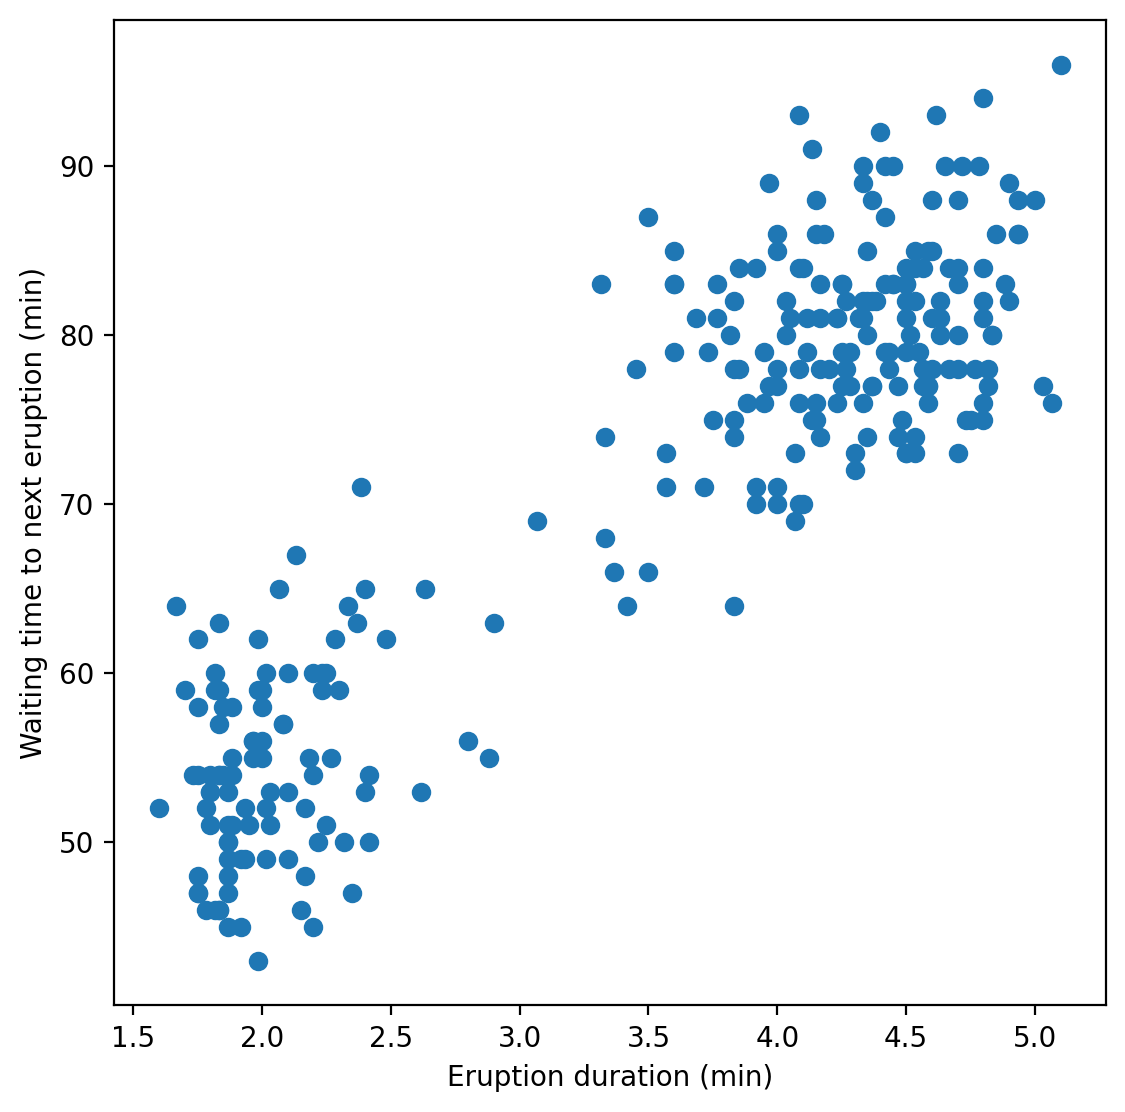

In [4]:
fig = plt.figure(figsize=(6.4, 6.4), dpi=200)
ax = plt.axes()

ax.scatter(x[:, 0], x[:, 1])
ax.set_xlabel("Eruption duration (min)")
ax.set_ylabel("Waiting time to next eruption (min)")

plt.savefig("figures/lec7/faithful-data.png", dpi=200)

plt.show()

In [7]:
# Utils for plotting GMMs
from scipy.stats import multivariate_normal, multinomial
from matplotlib.patches import Ellipse

def _plot_cov(ax, cov, pos):
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    
    w, h = 4 * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=w, height=h, 
                    angle=theta, alpha=0.25)
    ax.add_artist(ellip)

def make_plot(x, r=None, mu=None, sigma=None, ll=None, axis_labels=None, filename=None):
    fig = plt.figure(figsize=(6.4, 6.4), dpi=200)
    ax = plt.axes()
    
    if r is None:
        ax.scatter(x[:, 0], x[:, 1])
    else:
        clusters = np.argmax(r, axis=1)
        ax.scatter(x[:, 0], x[:, 1], c=clusters)
    
    if mu is not None:
        ax.scatter(mu[:, 0], mu[:, 1])
        
    if sigma is not None:
        n_clusters = sigma.shape[0]
        
        for k in range(n_clusters):
            _plot_cov(ax, sigma[k], mu[k])
            
    if ll is not None:
        ax.set(title=r"$ll = {}$".format(ll))

    if axis_labels is not None:
        ax.set_xlabel(axis_labels[0])
        ax.set_ylabel(axis_labels[1])

    if filename is not None:
        plt.savefig(filename)
                 
    plt.show()

In [8]:
# Center data
x = x - np.mean(x, axis=0)
x = x / np.std(x, axis=0)

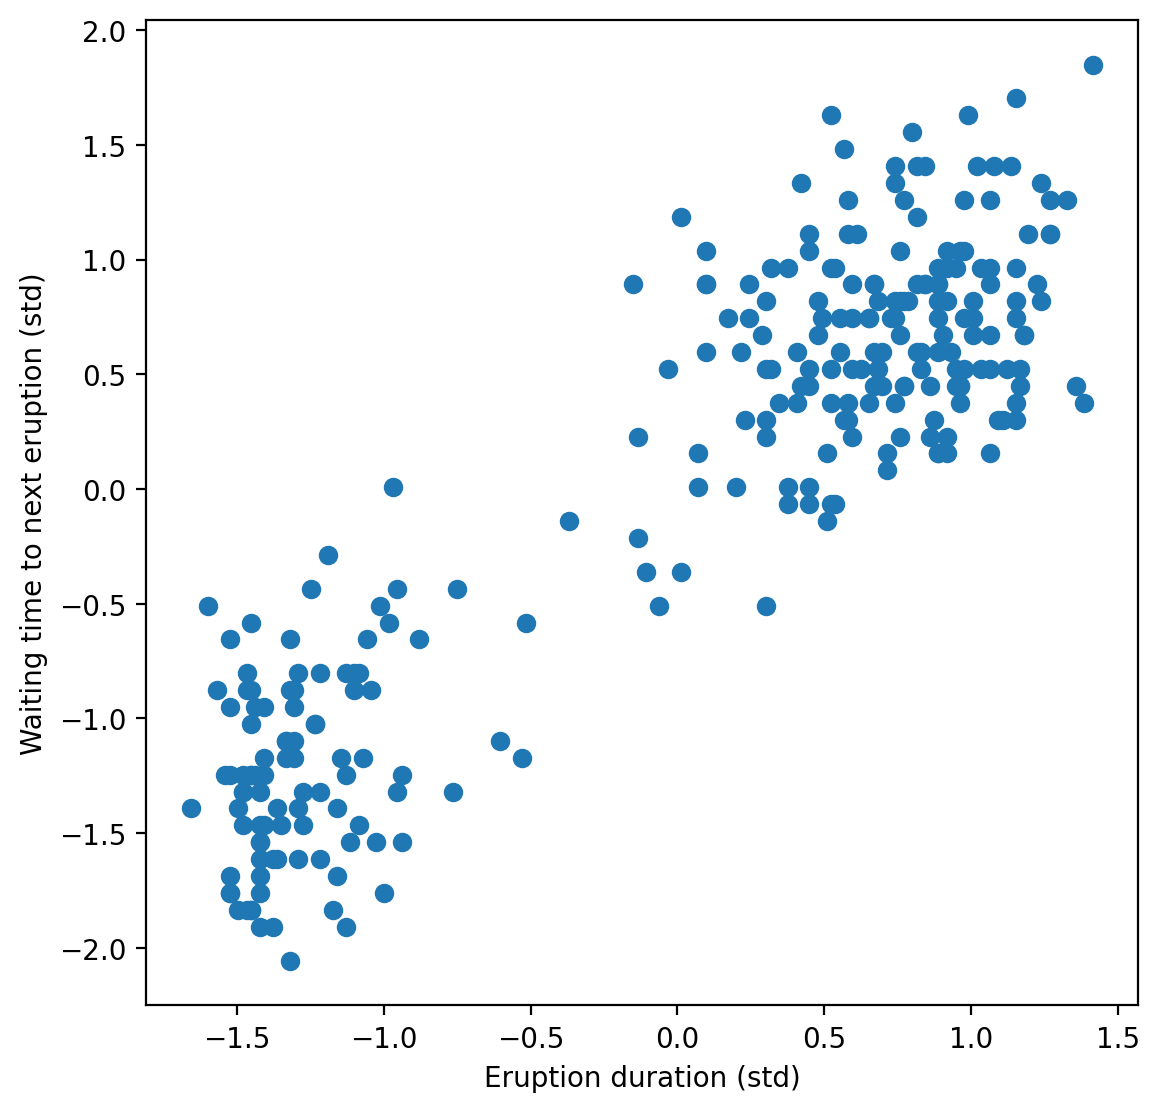

In [9]:
make_plot(x, axis_labels=["Eruption duration (std)", "Waiting time to next eruption (std)"])

## Expectation-Maximization

In [10]:
# Log-likelihood p(x | pi, mu, sigma)   
def ll(x, pi, mu, sigma):
    n_samples = len(x)
    n_clusters = len(pi)
    
    l = np.zeros((n_samples, n_clusters))
    
    for k in range(n_clusters):
        l[:, k] = pi[k] * multivariate_normal(mu[k], sigma[k]).pdf(x)
        
    return np.log(l.sum(axis=1)).mean()

In [11]:
# E-step 
def e_step(x, pi, mu, sigma):
    # Compute the posterior r[i, j] = p(z=j | x_i), for i=1->N, j=1->K
    # (<=> p_theta_t(z|x))
    n_samples = len(x)
    n_clusters = len(pi)

    r = np.zeros((n_samples, n_clusters))

    for k in range(n_clusters):
        r[:, k] = pi[k] * multivariate_normal(mu[k], sigma[k]).pdf(x)

    r = r / np.sum(r, axis=1).reshape(-1, 1)
    
    return r

In [12]:
# M-step
def m_step(x, r):
    # Maximize E_r [ log p(x, z | pi, mu, sigma) ]
    n_samples, n_clusters = r.shape
    
    pi = np.empty(n_clusters)
    mu = np.empty((n_clusters, 2))
    sigma = np.empty((n_clusters, 2, 2))
    
    N = np.sum(r, axis=0)

    for k in range(n_clusters):
        mu[k] = np.sum(r[:, k].reshape(-1, 1) * x, axis=0) / N[k]

    for k in range(n_clusters):
        s = np.array([[0.0, 0.0], [0.0, 0.0]])

        for i in range(n_samples):
            s += r[i, k] * np.outer(x[i] - mu[k], x[i] - mu[k])

        s /= N[k]
        sigma[k] = s
        
    pi = N / n_samples
        
    return pi, mu, sigma

In [25]:
# Initialization
n_samples = len(x)
n_clusters = 2

pi = np.ones(n_clusters) / n_clusters
mu = np.random.randn(n_clusters, 2)
sigma = np.array([[1.0, 0.0], [0.0, 1.0]]) * 0.5
sigma = np.tile(sigma, [n_clusters, 1, 1])

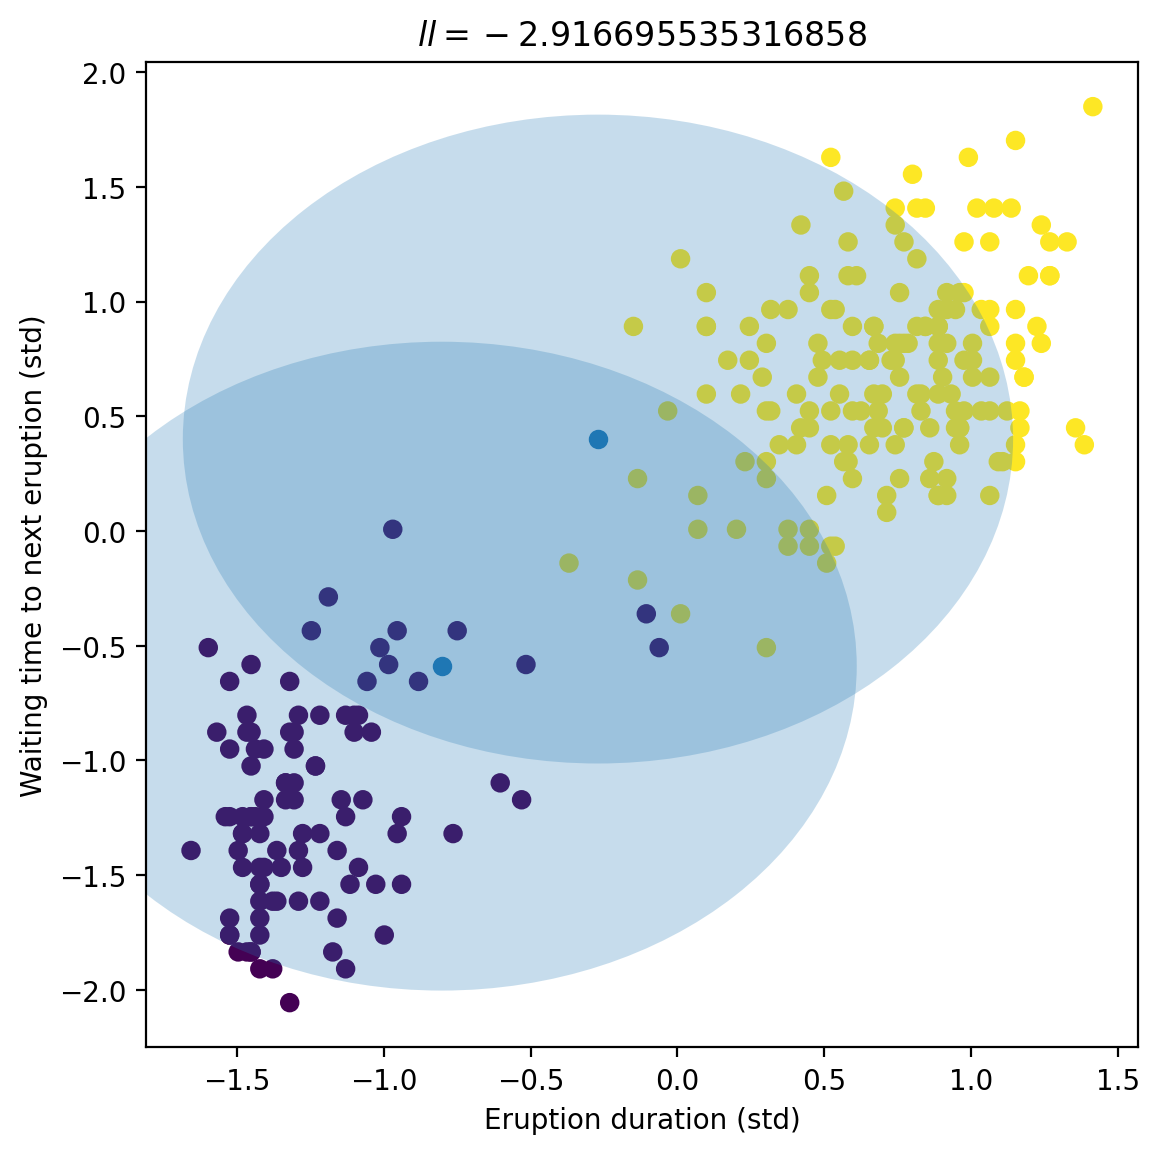

In [26]:
r = e_step(x, pi, mu, sigma)
i = 0
make_plot(x, r, mu, sigma, ll=ll(x, pi, mu, sigma), axis_labels=["Eruption duration (std)", "Waiting time to next eruption (std)"], filename=f"figures/lec7/faithful-gmm-{i}.png")

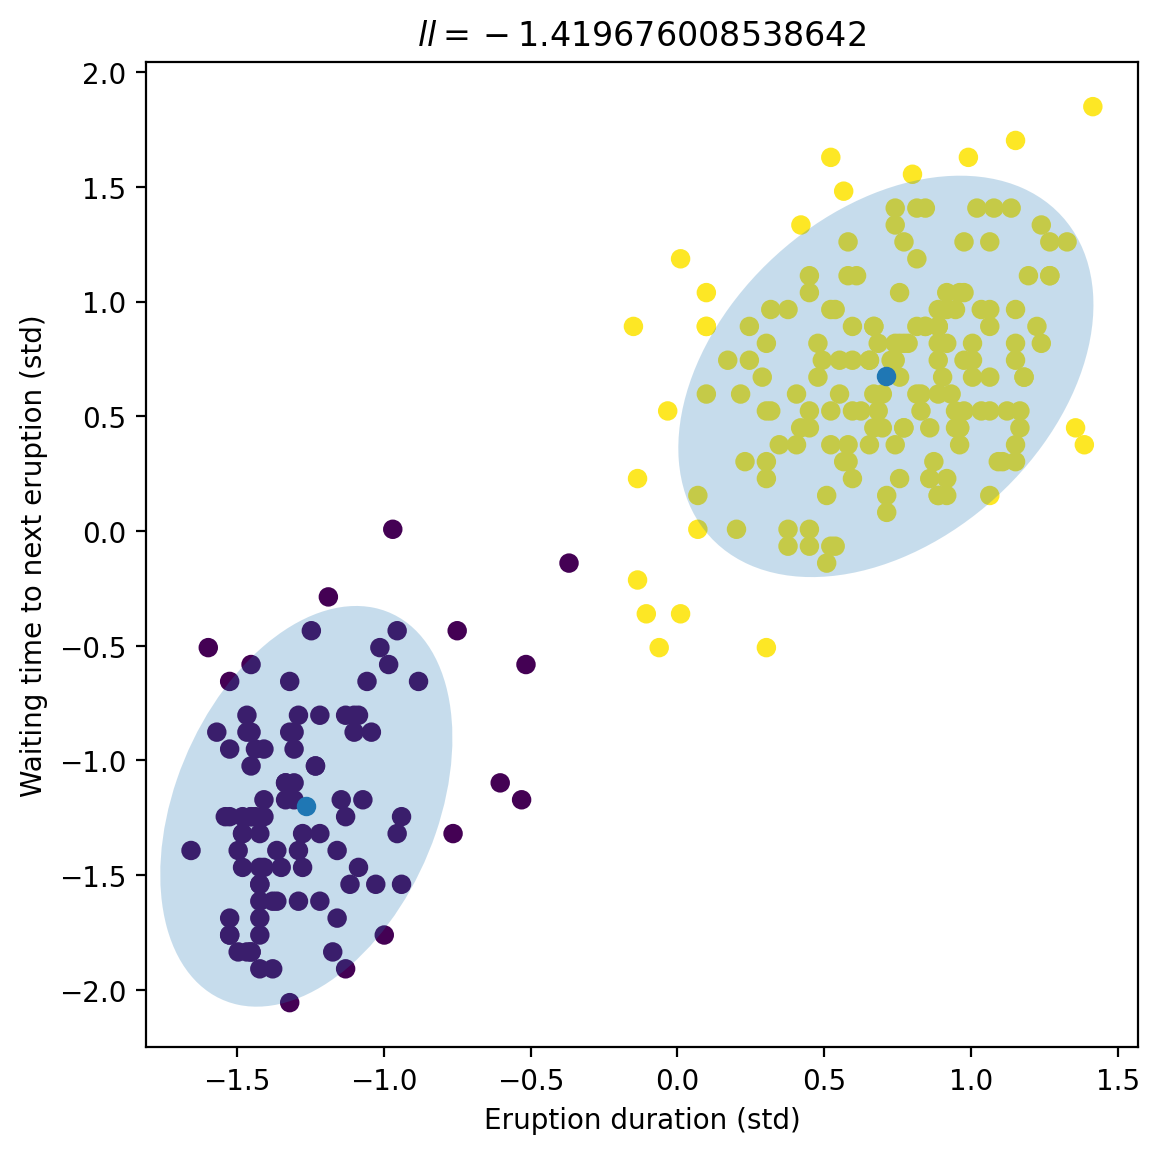

In [30]:
# Iterate manually until convergence
r = e_step(x, pi, mu, sigma)
pi, mu, sigma = m_step(x, r)
i += 1
make_plot(x, r, mu, sigma, ll=ll(x, pi, mu, sigma), axis_labels=["Eruption duration (std)", "Waiting time to next eruption (std)"], filename=f"figures/lec7/faithful-gmm-{i}.png")

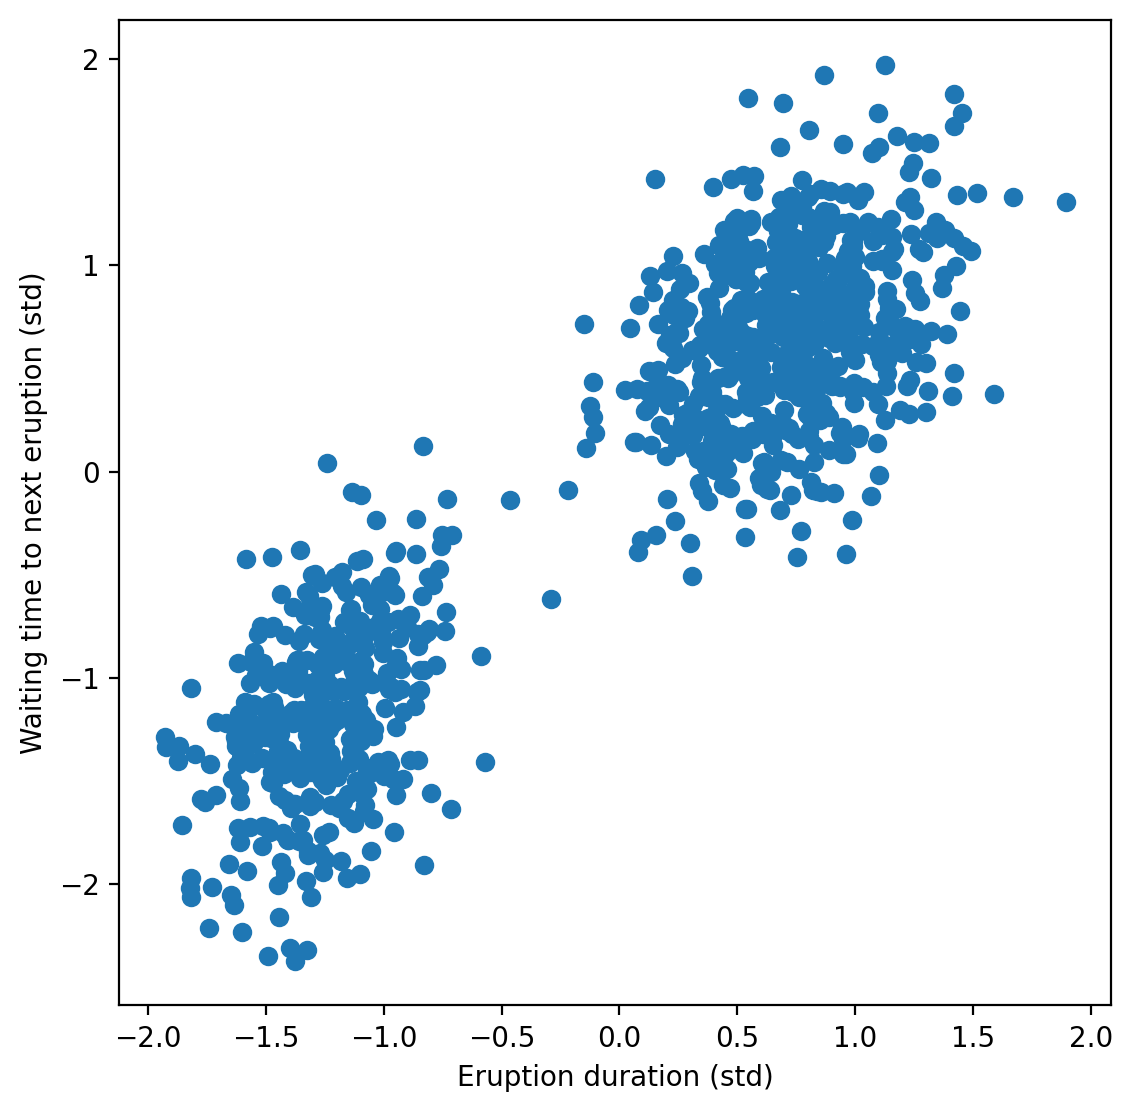

In [32]:
# Simulate new data
def simulate(n_samples, pi, mu, sigma):
    z = np.argmax(multinomial(1, pi).rvs(n_samples), axis=1)
    x = np.zeros((n_samples, 2))
    
    for i in range(n_samples):
        x[i] = multivariate_normal(mu[z[i]], sigma[z[i]]).rvs()
        
    return x

make_plot(simulate(1000, pi, mu, sigma), axis_labels=["Eruption duration (std)", "Waiting time to next eruption (std)"])